# Testing indexing mPOD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.signal import firwin  # To create FIR kernels
from tqdm import tqdm
from modulo_vki.utils._utils import conv_m, switch_eigs

# TODO: instead of computing the min of modes between SAT and the number of frequencies, we should compute the number of modes between SAT and the number of requested modes by the user.

def temporal_basis_mPOD(K, Nf, Ex, F_V, Keep, boundaries, MODE='reduced', 
                        dt=1,FOLDER_OUT: str = "./", MEMORY_SAVING: bool = False,SAT: int = 100,
                        n_Modes=10, eig_solver: str = 'svd_sklearn_randomized'):
    '''
    This function computes the PSIs for the mPOD. In this implementation, a "dft-trick" is proposed, in order to avoid
    expansive SVDs. Randomized SVD is used by default for the diagonalization.
    
    :param K: 
        np.array  Temporal correlation matrix
    :param dt: float.   
        1/fs, the dt between snapshots. Units in seconds.
    :param Nf: 
        np.array. Vector collecting the order of the FIR filters used in each scale.
    :param Ex: int.
        Extension at the boundaries of K to impose the boundary conditions (see boundaries). It must be at least as Nf.
    :param F_V: np.array. 
        Frequency splitting vector, containing the frequencies of each scale (see article). If the time axis is in seconds, these frequencies are in Hz.
    :param Keep: np.array. 
        Vector defining which scale to keep.
    :param boundaries: str -> {'nearest', 'reflect', 'wrap' or 'extrap'}. 
        In order to avoid 'edge effects' if the time correlation matrix is not periodic, several boundary conditions can be used. Options are (from scipy.ndimage.convolve):
        ‘reflect’ (d c b a | a b c d | d c b a)    The input is extended by reflecting about the edge of the last pixel.
        ‘nearest’ (a a a a | a b c d | d d d d)    The input is extended by replicating the last pixel.
        ‘wrap’ (a b c d | a b c d | a b c d)       The input is extended by wrapping around to the opposite edge.
    :param MODE: tr -> {‘reduced’, ‘complete’, ‘r’, ‘raw’}
        As a final step of this algorithm, the orthogonality is imposed via a QR-factorization. This parameterd define how to perform such factorization, according to numpy.
        Options: this is a wrapper to np.linalg.qr(_, mode=MODE). Check numpy's documentation.
        if ‘reduced’ The final basis will not necessarely be full. If ‘complete’ The final basis will always be full
    :param FOLDER_OUT: str. 
        This is the directory where intermediate results will be stored if the memory saving is active.It will be ignored if MEMORY_SAVING=False.              
    :param MEMORY_SAVING: Bool. 
        If memory saving is active, the results will be saved locally.  Nevertheless, since Psi_M is usually not expensive, it will be returned.        
    :param SAT: int.
        Maximum number of modes per scale. The user can decide how many modes to compute; otherwise, modulo set the default SAT=100.
    :param n_Modes: int. 
        Total number of modes that will be finally exported   
    :param eig_solver: str. 
        This is the eigenvalue solver that will be used. Refer to eigs_swith for the options.      
    :return PSI_M: np.array. 
        The mPOD PSIs. Yet to be sorted ! 
    '''

    if Ex < np.max(Nf):
        raise RuntimeError("For the mPOD temporal basis computation Ex must be larger than or equal to Nf")

    #Converting F_V in radiants and initialise number of scales M
    Fs = 1 / dt
    F_Bank_r = F_V * 2 / Fs
    M = len(F_Bank_r) #+ 1

    # Loop over the scales to show the transfer functions
    Psi_M = np.array([])
    Lambda_M = np.array([])
    n_t = K.shape[1]
    
   # if K_S:
   #     Ks = np.zeros((n_t, n_t, M + 1))

    #DFT-trick below: computing frequency bins.
    Freqs = np.fft.fftfreq(n_t) * Fs

    print("Filtering and Diagonalizing H scale: \n")

    #Filtering and computing eigenvectors

    for m in tqdm(range(0, M)):
        # Generate the 1d filter for this
        if m < 1:
            if Keep[m] == 1:
                # Low Pass Filter
                h_A = firwin(Nf[m], F_Bank_r[m], window='hamming')  # Low-pass
                # Filter K_LP
                print('\n Filtering Largest Scale - low pass ' + str(m) + '/' + str(M))
                K_L = conv_m(K=K, h=h_A, Ex=Ex, boundaries=boundaries)
                # R_K = np.linalg.matrix_rank(K_L, tol=None, hermitian=True)
                '''We replace it with an estimation based on the non-zero freqs the cut off frequency of the scale is '''
                F_CUT = F_Bank_r[m] * Fs / 2
                Indices = np.argwhere(np.abs(Freqs) < F_CUT) 
                
                R_K = np.min([len(Indices), SAT]) 
                # R_K = np.min(R_K, n_Modes) # we take the min between the number of frequencies and the number of modes requested 
                # R_K = min(len(Indices), SAT, n_Modes) 
                
                print(str(len(Indices)) + ' Modes Estimated')
                print('\n Diagonalizing Largest Scale')
                
                Psi_P, Lambda_P = switch_eigs(K_L, R_K, eig_solver) #svds_RND(K_L, R_K)
                Psi_M=Psi_P
                Lambda_M=Lambda_P
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  

        elif m > 0 and m < M - 1:
            if Keep[m] == 1:
                # print(m)
                print('\n Working on Scale '+str(m)+'/'+str(M))
                # This is the 1d Kernel for Band pass
                h1d_H = firwin(Nf[m], [F_Bank_r[m], F_Bank_r[m + 1]], pass_zero=False)  # Band-pass
                F_CUT1 = F_Bank_r[m] * Fs / 2
                F_CUT2 = F_Bank_r[m + 1] * Fs / 2
                Indices = np.argwhere((np.abs(Freqs) > F_CUT1) & (np.abs(Freqs) < F_CUT2))
                R_K = np.min([len(Indices), SAT])  # number of frequencies here
                print(str(len(Indices)) + ' Modes Estimated')
                # print('Filtering H Scale ' + str(m + 1) + '/' + str(M))
                K_H = conv_m(K, h1d_H, Ex, boundaries)
                # Ks[:, :, m + 1] = K_H  # Intermediate band-pass
                print('Diagonalizing H Scale ' + str(m + 1) + '/' + str(M))
                # R_K = np.linalg.matrix_rank(K_H, tol=None, hermitian=True)
                Psi_P, Lambda_P = switch_eigs(K_H, R_K, eig_solver) #svds_RND(K_H, R_K)  # Diagonalize scale
                
                if np.shape(Psi_M)[0]==0: # if this is the first contribute to the basis
                    Psi_M=Psi_P
                    Lambda_M=Lambda_P
                else:                    
                    Psi_M = np.concatenate((Psi_M, Psi_P), axis=1)  # append to the previous
                    Lambda_M = np.concatenate((Lambda_M, Lambda_P), axis=0)
                    
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  
      
        else: # this is the case m=M: this is a high pass
            if Keep[m] == 1:
                print('Working on Scale - high-pass '+str(m)+'/'+str(M))
                # This is the 1d Kernel for High Pass (last scale)
                h1d_H = firwin(Nf[m], F_Bank_r[m], pass_zero=False)
                F_CUT1 = F_Bank_r[m] * Fs / 2
                Indices = np.argwhere((np.abs(Freqs) > F_CUT1))
                R_K = len(Indices)
                R_K = np.min([len(Indices), SAT])  # number of frequencies here
                print(str(len(Indices)) + ' Modes Estimated')
                print('Filtering H Scale ' + str(m + 1) + '/ ' + str(M))
                K_H = conv_m(K, h1d_H, Ex, boundaries)
                # Ks[:, :, m + 1] = K_H  # Last (high pass) scale
                print('Diagonalizing H Scale ' + str(m + 1) + '/ ' + str(M))
                # R_K = np.linalg.matrix_rank(K_H, tol=None, hermitian=True)
                Psi_P, Lambda_P = switch_eigs(K_H, R_K, eig_solver) #svds_RND(K_H, R_K)  # Diagonalize scale
                Psi_M = np.concatenate((Psi_M, Psi_P), axis=1)  # append to the previous
                Lambda_M = np.concatenate((Lambda_M, Lambda_P), axis=0)
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  

    # Now Order the Scales
    Indices = np.flip(np.argsort(Lambda_M))  # find indices for sorting in decreasing order
    Psi_M = Psi_M[:, Indices]  # Sort the temporal structures
    #print(f"Size psis in mpodtime = {np.shape(Psi_M)}")
    # Now we complete the basis via re-orghotonalization
    print('\n QR Polishing...')
    PSI_M, R = np.linalg.qr(Psi_M, mode=MODE)
    print('Done!')

    if MEMORY_SAVING:
        os.makedirs(FOLDER_OUT + '/mPOD', exist_ok=True)
        np.savez(FOLDER_OUT + '/mPOD/Psis', Psis=PSI_M)
    
    return PSI_M[:,0:n_Modes]


def spatial_basis_mPOD(D, PSI_M, N_T, N_PARTITIONS, N_S, MEMORY_SAVING, FOLDER_OUT, SAVE: bool = False,weights: np.array = np.array([])):
    """
    Given the temporal basis of the mPOD now the spatial ones are computed
    
    :param D: 
        Snapshot matrix D: if memory savig is active, this is ignored.    
    :param PSI_M: np.array.: 
        The mPOD temporal basis Psi tentatively assembled from all scales
    :param N_T: int. 
        Number of snapshots
    :param N_PARTITIONS: int. 
        Number of partitions in the memory saving
    :param N_S: int. 
        Number of grid points in space
    :param MEMORY_SAVING: bool. 
        Inherited from main class, if True turns on the MEMORY_SAVING feature, loading the partitions and starting the proper algorithm  
    :param FOLDER_OUT: str. 
        Folder in which the results are saved if SAVE_SPATIAL_POD = True
    :param SAVE_SPATIAL_POD: bool.
        If True, results are saved on disk and released from memory
    :param weights:  np.array
        weight vector [w_i,....,w_{N_s}] where w_i = area_cell_i/area_grid. Only needed if grid is non-uniform & MEMORY_SAVING== True
    :return: Phi_M, Psi_M, Sigma_M: np.arrays. The final (sorted) mPOD decomposition
    """
    
    R1 = 0; R2 = 0
    R = PSI_M.shape[1]
    PHI_M_SIGMA_M = np.dot(D, (PSI_M))
    # Initialize the output
    PHI_M = np.zeros((N_S, R))
    SIGMA_M = np.zeros((R))

    for i in tqdm(range(0, R)):
        # print('Completing mPOD Mode ' + str(i))
        # Assign the norm as amplitude
        if weights.size == 0:
            SIGMA_M[i] = np.linalg.norm(PHI_M_SIGMA_M[:, i])
        else:
            SIGMA_M[i] = np.linalg.norm(PHI_M_SIGMA_M[:, i]*np.sqrt(weights))
        # Normalize the columns of C to get spatial modes
        PHI_M[:, i] = PHI_M_SIGMA_M[:, i] / SIGMA_M[i]

    Indices = np.flipud(np.argsort(SIGMA_M))  # find indices for sorting in decreasing order
    Sorted_Sigmas = SIGMA_M[Indices]  # Sort all the sigmas
    Phi_M = PHI_M[:, Indices]  # Sorted Spatial Structures Matrix
    Psi_M = PSI_M[:, Indices]  # Sorted Temporal Structures Matrix
    Sigma_M = Sorted_Sigmas  # Sorted Amplitude Matrix

    if SAVE:
        '''Saving results in MODULO tmp proper folder'''
        os.makedirs(FOLDER_OUT + '/mPOD/', exist_ok=True)
        np.savez(FOLDER_OUT + "/mPOD/sorted_phis", Phi_M)
        np.savez(FOLDER_OUT + "/mPOD/sorted_psis", Psi_M)
        np.savez(FOLDER_OUT + "/mPOD/sorted_sigma", Sorted_Sigmas)

    return Phi_M, Psi_M, Sigma_M


def CorrelationMatrix(N_T, N_PARTITIONS=1, MEMORY_SAVING=False, FOLDER_OUT='./', SAVE_K=False, D=None,weights = np.array([])):
    """
    This method computes the temporal correlation matrix, given a data matrix as input. It's possible to use memory saving
    then splitting the computing in different tranches if computationally heavy. If D has been computed using MODULO
    then the dimension dim_col and N_PARTITIONS is automatically loaded

    :param N_T: int. Number of temporal snapshots
    :param D: np.array. Data matrix
    :param SAVE_K: bool. If SAVE_K=True, the matrix K is saved on disk. If the MEMORY_SAVING feature is active, this is done by default.
    :param MEMORY_SAVING: bool. If MEMORY_SAVING = True, the computation of the correlation matrix is done by steps. It requires the data matrix to be partitioned, following algorithm in MODULO._data_processing.
    :param FOLDER_OUT: str. Folder in which the temporal correlation matrix will be stored
    :param N_PARTITIONS: int. Number of partitions to be read in computing the correlation matrix. If _data_processing is used to partition the data matrix, this is inherited from the main class
    :param weights: weight vector [w_i,....,w_{N_s}] where w_i = area_cell_i/area_grid. Only needed if grid is non-uniform & MEMORY_SAVING== True
    :return: K (: np.array) if the memory saving is not active. None type otherwise.
    """

    if not MEMORY_SAVING:
        print("\n Computing Temporal correlation matrix K ...")
        K = np.dot(D.T, D)
    
    return K

In [189]:

def compute_mPOD(D, Nf, Ex, F_V, Keep, SAT, boundaries, MODE,
                 dt, N_S,  N_T, N_PARTITIONS, MEMORY_SAVING, FOLDER_OUT, SAVE_K, SAVE=False, n_Modes=10,
                 eig_solver: str = 'svd_sklearn_randomized'):
        
        """
        This function computes the temporal structures of each scale in the mPOD, as in step 4 of the algorithm
        ref: Multi-Scale Proper Orthogonal Decomposition of Complex Fluid Flows - M. A. Mendez et al.

        :param K: np.array
                Temporal correlation matrix

        :param Nf: np.array
                Order of the FIR filters that are used to isolate each of the scales

        :param Ex: int
                Extension at the boundaries of K to impose the boundary conditions (see boundaries)
                It must be at least as Nf.

        :param F_V: np.array
                Frequency splitting vector, containing the frequencies of each scale (see article).
                If the time axis is in seconds, these frequencies are in Hz.

        :param Keep: np.array
                Scale keep

        :param boundaries: str -> {'nearest', 'reflect', 'wrap' or 'extrap'}
                Define the boundary conditions for the filtering process, in order to avoid edge effects.
                The available boundary conditions are the classic ones implemented for image processing:
                nearest', 'reflect', 'wrap' or 'extrap'. See also https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html

        :param MODE: str -> {‘reduced’, ‘complete’, ‘r’, ‘raw’}
                A QR factorization is used to enforce the orthonormality of the mPOD basis, to compensate
                for the non-ideal frequency response of the filters.
                The option MODE from np.linalg.qr carries out this operation.

        :param SAT: Maximum number of modes per scale.
                Only used for mPOD (max number of modes per scale)

        :param dt: float
                temporal step

        :return Phi_M: np.array
                mPOD Phis (Matrix of spatial structures)
        :return Psi_M: np.array
                mPOD Psis (Matrix of temporal structures)
        :return Sigma_M: np.array
                mPOD Sigmas (vector of amplitudes, i.e. the diagonal of Sigma_M

        """
        K = CorrelationMatrix(N_T, N_PARTITIONS, MEMORY_SAVING, FOLDER_OUT, SAVE_K, D)


        PSI_M = temporal_basis_mPOD(K, Nf=Nf, Ex=Ex, F_V=F_V, Keep=Keep, boundaries=boundaries,
                                MODE=MODE, dt=dt, FOLDER_OUT=FOLDER_OUT,
                                n_Modes=n_Modes, MEMORY_SAVING=MEMORY_SAVING, SAT=SAT,
                                eig_solver=eig_solver)

        Phi_M, Psi_M, Sigma_M = spatial_basis_mPOD(D, PSI_M, N_T=N_T, N_PARTITIONS=N_PARTITIONS,
                                                N_S=N_S, MEMORY_SAVING=MEMORY_SAVING,
                                                FOLDER_OUT=FOLDER_OUT,
                                                SAVE=SAVE)

        return Phi_M, Psi_M, Sigma_M

Generate signal 

In [169]:
t = np.linspace(0, 5, 1000)
Fs = 1 / (t[1] - t[0])
x = np.linspace(0, 1, 100)
# Signal composed of c1, c2 and s
Amp = np.array([1,5,10]) # Amplitude of signals
freq = np.array([1,5,10]) # frequency of c1,c2,s
c1 = Amp[0]*np.cos(freq[0] * t *2* np.pi)
c2 = Amp[1]*np.cos(freq[1] * t *2* np.pi)
s = Amp[2]*np.sin(freq[2] * t *2* np.pi)
# gauss signal
center, width = 2.5, 0.5
gauss = np.exp(-((t - center)**2) / (2 * width**2))
s_gauss = s*gauss
X = np.zeros([len(x), len(t)])
for i in range(len(x)):
    X[i, :] = c1 + c2 + s_gauss

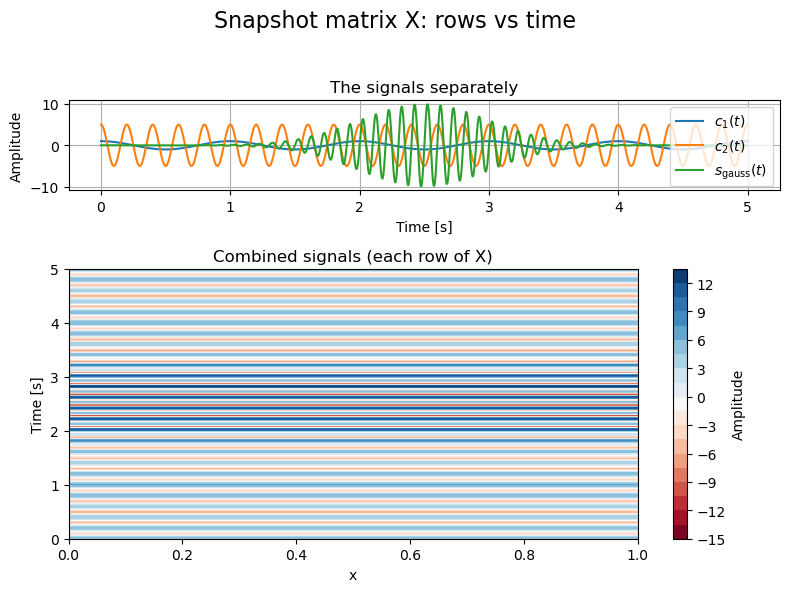

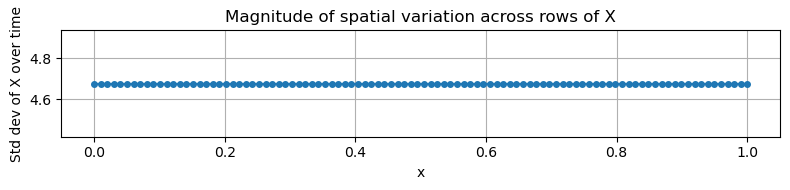

In [147]:
# fig, axes = plt.subplots(2, 1, figsize=(8, 4)) # 3 rows,
# # First plot
# axes[0].plot(t, c1, label=r'$c_1(t)$')
# axes[0].plot(t, c2, label=r'$c_2(t)$')
# axes[0].plot(t, s_gauss, label=r'$s_{\mathrm{gauss}}(t)$')
# axes[0].set_title('The signals seperately')
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Amplitude')
# axes[0].legend()
# # Second plot contourf 
# axes[1].set_aspect('auto')
# axes[1].contourf(x, t, X.T, 20, cmap='RdBu')
# axes[1].set_title('combined signals')
# axes[1].set_xlabel('x')
# axes[1].set_ylabel('Time')
# axes[1].set_xlim([0, 1])
# axes[1].set_ylim([0, 5])
# fig.suptitle('Each row in data matrix X', fontsize=20)
# plt.tight_layout() # Leave space for suptitle
# plt.show()
# 1) Plot with bigger second panel
fig, axes = plt.subplots(2, 1, figsize=(8, 6),
                         gridspec_kw={'height_ratios': [1, 3]})
axes[0].plot(t, c1, label=r'$c_1(t)$')
axes[0].plot(t, c2, label=r'$c_2(t)$')
axes[0].plot(t, s_gauss, label=r'$s_{\mathrm{gauss}}(t)$')
axes[0].set_title('The signals separately')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True)

im = axes[1].contourf(x, t, X.T, 20, cmap='RdBu')
axes[1].set_title('Combined signals (each row of X)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Time [s]')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 5])
fig.colorbar(im, ax=axes[1], orientation='vertical', label='Amplitude')

fig.suptitle('Snapshot matrix X: rows vs time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2) Quantify and plot spatial variation
spatial_std = np.std(X, axis=1)

fig2, ax2 = plt.subplots(figsize=(8, 2))
ax2.plot(x, spatial_std, '-o', markersize=4)
ax2.set_xlabel('x')
ax2.set_ylabel('Std dev of X over time')
ax2.set_title('Magnitude of spatial variation across rows of X')
ax2.grid(True)
plt.tight_layout()
plt.show()

Top 5 spatial eigenvalues: [2.18763710e+03 1.69937814e-12 1.47228877e-12 1.02819930e-12
 9.92025529e-13]
Top 5 temporal eigenvalues from SVD: [2.18763710e+04 2.18414144e-28 2.18414144e-28 2.18414144e-28
 2.18414144e-28]


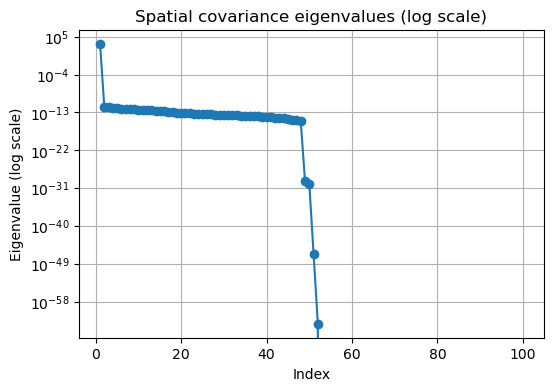

In [149]:
X_orig = X.copy()
X_orig -= X_orig.mean(axis=1)[:, None]

# Compute spatial covariance and its eigenvalues
C_spatial = (X_orig @ X_orig.T) / X_orig.shape[1]  # n_x x n_x
eigvals_spatial = np.linalg.eigvalsh(C_spatial)

# Compute temporal correlation and its eigenvalues
C_temporal = (X_orig.T @ X_orig) / X_orig.shape[0]  # n_t x n_t (but we'll compute a few)
# compute top 5 eigenvalues of temporal correlation via SVD
U, S, Vt = np.linalg.svd(X_orig, full_matrices=False)
eigvals_temporal = S**2 / X_orig.shape[0]

# Plot the sorted spatial‐covariance eigenvalues
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(1, len(eigvals_spatial)+1), np.sort(eigvals_spatial)[::-1], 'o-')
ax.set_yscale('log')
ax.set_xlabel('Index')
ax.set_ylabel('Eigenvalue (log scale)')
ax.set_title('Spatial covariance eigenvalues (log scale)')
ax.grid(True)

# Print the first few eigenvalues
print("Top 5 spatial eigenvalues:", np.sort(eigvals_spatial)[::-1][:5])
print("Top 5 temporal eigenvalues from SVD:", eigvals_temporal[:5])

In [171]:
t = np.linspace(0, 5, 1000)
Fs = 1 / (t[1] - t[0])
x = np.linspace(0, 1, 100)
# Signal composed of c1, c2 and s
Amp = np.array([1,5,10]) # Amplitude of signals
freq = np.array([1,5,10]) # frequency of c1,c2,s
c1 = Amp[0]*np.cos(freq[0] * t *2* np.pi)
c2 = Amp[1]*np.cos(freq[1] * t *2* np.pi)
s = Amp[2]*np.sin(freq[2] * t *2* np.pi)
# gauss signal
center, width = 2.5, 0.5
gauss = np.exp(-((t - center)**2) / (2 * width**2))
s_gauss = s*gauss
X = np.zeros([len(x), len(t)])
x_sinus = np.sin(2*np.pi*x*10)

X = x_sinus[:, None] * (c1 + c2 + s_gauss[None, :]) + np.random.normal(0, 0.1, (len(x), len(t)))

# for i in range(len(x)):
#     X[i, :] = c1 + c2 + s_gauss

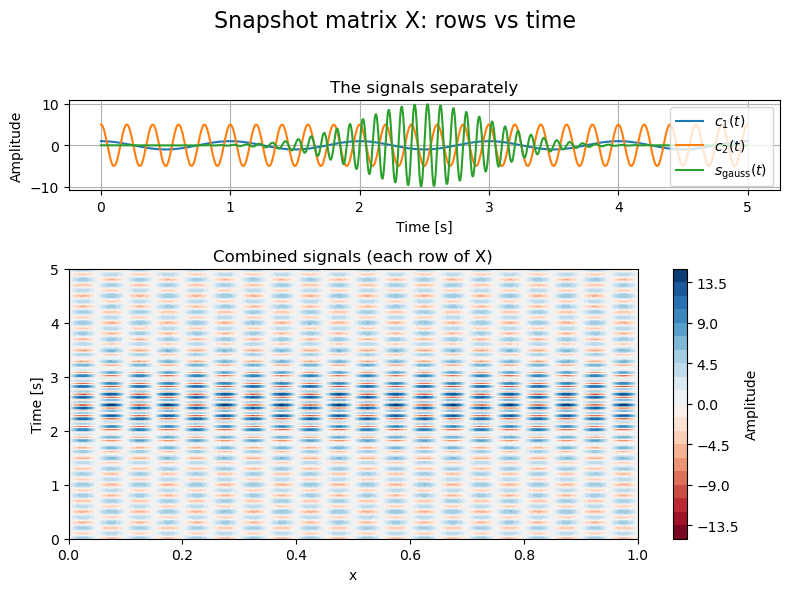

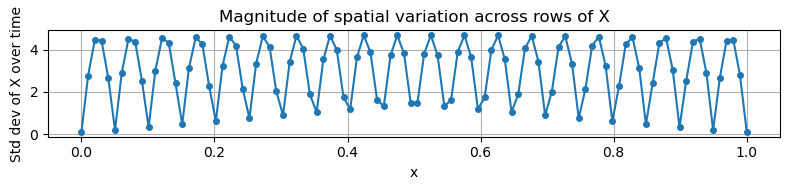

In [183]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6),
                         gridspec_kw={'height_ratios': [1, 3]})
axes[0].plot(t, c1, label=r'$c_1(t)$')
axes[0].plot(t, c2, label=r'$c_2(t)$')
axes[0].plot(t, s_gauss, label=r'$s_{\mathrm{gauss}}(t)$')
axes[0].set_title('The signals separately')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True)

im = axes[1].contourf(x, t, X.T, 20, cmap='RdBu')
axes[1].set_title('Combined signals (each row of X)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Time [s]')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 5])
fig.colorbar(im, ax=axes[1], orientation='vertical', label='Amplitude')

fig.suptitle('Snapshot matrix X: rows vs time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2) Quantify and plot spatial variation
spatial_std = np.std(X, axis=1)

fig2, ax2 = plt.subplots(figsize=(8, 2))
ax2.plot(x, spatial_std, '-o', markersize=4)
ax2.set_xlabel('x')
ax2.set_ylabel('Std dev of X over time')
ax2.set_title('Magnitude of spatial variation across rows of X')
ax2.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

def temporal_basis_mPOD(K, Nf, Ex, F_V, Keep, boundaries, MODE='reduced', 
                        dt=1,FOLDER_OUT: str = "./", MEMORY_SAVING: bool = False,SAT: int = 100,
                        n_Modes=10, eig_solver: str = 'svd_sklearn_randomized'):
    '''
    This function computes the PSIs for the mPOD. In this implementation, a "dft-trick" is proposed, in order to avoid
    expansive SVDs. Randomized SVD is used by default for the diagonalization.
    
    :param K: 
        np.array  Temporal correlation matrix
    :param dt: float.   
        1/fs, the dt between snapshots. Units in seconds.
    :param Nf: 
        np.array. Vector collecting the order of the FIR filters used in each scale.
    :param Ex: int.
        Extension at the boundaries of K to impose the boundary conditions (see boundaries). It must be at least as Nf.
    :param F_V: np.array. 
        Frequency splitting vector, containing the frequencies of each scale (see article). If the time axis is in seconds, these frequencies are in Hz.
    :param Keep: np.array. 
        Vector defining which scale to keep.
    :param boundaries: str -> {'nearest', 'reflect', 'wrap' or 'extrap'}. 
        In order to avoid 'edge effects' if the time correlation matrix is not periodic, several boundary conditions can be used. Options are (from scipy.ndimage.convolve):
        ‘reflect’ (d c b a | a b c d | d c b a)    The input is extended by reflecting about the edge of the last pixel.
        ‘nearest’ (a a a a | a b c d | d d d d)    The input is extended by replicating the last pixel.
        ‘wrap’ (a b c d | a b c d | a b c d)       The input is extended by wrapping around to the opposite edge.
    :param MODE: tr -> {‘reduced’, ‘complete’, ‘r’, ‘raw’}
        As a final step of this algorithm, the orthogonality is imposed via a QR-factorization. This parameterd define how to perform such factorization, according to numpy.
        Options: this is a wrapper to np.linalg.qr(_, mode=MODE). Check numpy's documentation.
        if ‘reduced’ The final basis will not necessarely be full. If ‘complete’ The final basis will always be full
    :param FOLDER_OUT: str. 
        This is the directory where intermediate results will be stored if the memory saving is active.It will be ignored if MEMORY_SAVING=False.              
    :param MEMORY_SAVING: Bool. 
        If memory saving is active, the results will be saved locally.  Nevertheless, since Psi_M is usually not expensive, it will be returned.        
    :param SAT: int.
        Maximum number of modes per scale. The user can decide how many modes to compute; otherwise, modulo set the default SAT=100.
    :param n_Modes: int. 
        Total number of modes that will be finally exported   
    :param eig_solver: str. 
        This is the eigenvalue solver that will be used. Refer to eigs_swith for the options.      
    :return PSI_M: np.array. 
        The mPOD PSIs. Yet to be sorted ! 
    '''

    if Ex < np.max(Nf):
        raise RuntimeError("For the mPOD temporal basis computation Ex must be larger than or equal to Nf")

    #Converting F_V in radiants and initialise number of scales M
    Fs  = 1/dt
    F_Bank_r = F_V * 2 / Fs

    # Loop over the scales to show the transfer functions
    Psi_M = np.array([])
    Lambda_M = np.array([])
    n_t = K.shape[1]
    
    Freqs = np.fft.fftfreq(n_t) * Fs
    
    print("Filtering and Diagonalizing H scale: \n")

    #Filtering and computing eigenvectors
    
    # add the first value to the filter bank 
    F_Bank_r = np.concatenate(([F_Bank_r[0]], F_Bank_r))
    Nf = np.concatenate(([Nf[0]], Nf))
    Keep = np.concatenate(([Keep[0]], Keep))
    
    M = len(F_Bank_r) 

    for m in tqdm(range(0, M)):
        # Generate the 1d filter for this
        if m < 1:
            if Keep[m] == 1:
                # Low Pass Filter
                h_A = firwin(Nf[m], F_Bank_r[m], window='hamming')
                # Filter K_LP
                print('\n Filtering Largest Scale')
                K_L = conv_m(K=K, h=h_A, Ex=Ex, boundaries=boundaries)
                # R_K = np.linalg.matrix_rank(K_L, tol=None, hermitian=True)
                '''We replace it with an estimation based on the non-zero freqs the cut off frequency of the scale is '''
                F_CUT = F_Bank_r[m] * Fs / 2
                Indices = np.argwhere(np.abs(Freqs) < F_CUT) 
                
                # R_K = np.min([len(Indices), SAT]) 
                # R_K = np.min(R_K, n_Modes) # we take the min between the number of frequencies and the number of modes requested 
                R_K = min(len(Indices), SAT, n_Modes) 
                
                print(str(len(Indices)) + ' Modes Estimated')
                print('\n Diagonalizing Largest Scale')
                
                Psi_P, Lambda_P = switch_eigs(K_L, R_K, eig_solver) #svds_RND(K_L, R_K)
                Psi_M=Psi_P
                Lambda_M=Lambda_P
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  

        elif m > 0 and m < M - 1:
            if Keep[m] == 1:
                # print(m)
                print('\n Working on Scale '+str(m)+'/'+str(M))
                # This is the 1d Kernel for Band pass
                h1d_H = firwin(Nf[m], [F_Bank_r[m], F_Bank_r[m + 1]], pass_zero=False)  # Band-pass
                F_CUT1 = F_Bank_r[m] * Fs / 2
                F_CUT2 = F_Bank_r[m + 1] * Fs / 2
                Indices = np.argwhere((np.abs(Freqs) > F_CUT1) & (np.abs(Freqs) < F_CUT2))
                R_K = np.min([len(Indices), SAT])  # number of frequencies here
                print(str(len(Indices)) + ' Modes Estimated')
                # print('Filtering H Scale ' + str(m + 1) + '/' + str(M))
                K_H = conv_m(K, h1d_H, Ex, boundaries)
                # Ks[:, :, m + 1] = K_H  # Intermediate band-pass
                print('Diagonalizing H Scale ' + str(m + 1) + '/' + str(M))
                # R_K = np.linalg.matrix_rank(K_H, tol=None, hermitian=True)
                Psi_P, Lambda_P = switch_eigs(K_H, R_K, eig_solver) #svds_RND(K_H, R_K)  # Diagonalize scale
                
                if np.shape(Psi_M)[0]==0: # if this is the first contribute to the basis
                    Psi_M=Psi_P
                    Lambda_M=Lambda_P
                else:                    
                    Psi_M = np.concatenate((Psi_M, Psi_P), axis=1)  # append to the previous
                    Lambda_M = np.concatenate((Lambda_M, Lambda_P), axis=0)
                    
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  
      
        else: # this is the case m=M: this is a high pass
            if Keep[m] == 1:
                print('Working on Scale '+str(m)+'/'+str(M))
                # This is the 1d Kernel for High Pass (last scale)
                h1d_H = firwin(Nf[m], F_Bank_r[m], pass_zero=False)
                F_CUT1 = F_Bank_r[m] * Fs / 2
                Indices = np.argwhere((np.abs(Freqs) > F_CUT1))
                R_K = len(Indices)
                R_K = np.min([len(Indices), SAT])  # number of frequencies here
                print(str(len(Indices)) + ' Modes Estimated')
                print('Filtering H Scale ' + str(m + 1) + '/ ' + str(M))
                K_H = conv_m(K, h1d_H, Ex, boundaries)
                # Ks[:, :, m + 1] = K_H  # Last (high pass) scale
                print('Diagonalizing H Scale ' + str(m + 1) + '/ ' + str(M))
                # R_K = np.linalg.matrix_rank(K_H, tol=None, hermitian=True)
                Psi_P, Lambda_P = switch_eigs(K_H, R_K, eig_solver) #svds_RND(K_H, R_K)  # Diagonalize scale
                Psi_M = np.concatenate((Psi_M, Psi_P), axis=1)  # append to the previous
                Lambda_M = np.concatenate((Lambda_M, Lambda_P), axis=0)
            else:
                print('\n Scale '+str(m)+' jumped (keep['+str(m)+']=0)')  

    # Now Order the Scales
    Indices = np.flip(np.argsort(Lambda_M))  # find indices for sorting in decreasing order
    Psi_M = Psi_M[:, Indices]  # Sort the temporal structures
    #print(f"Size psis in mpodtime = {np.shape(Psi_M)}")
    # Now we complete the basis via re-orghotonalization
    print('\n QR Polishing...')
    PSI_M, R = np.linalg.qr(Psi_M, mode=MODE)
    print('Done!')

    if MEMORY_SAVING:
        os.makedirs(FOLDER_OUT + '/mPOD', exist_ok=True)
        np.savez(FOLDER_OUT + '/mPOD/Psis', Psis=PSI_M)
    
    return PSI_M[:,0:n_Modes]


cut_freqs    = [3, 7]          # Hz
F_V          = np.array(cut_freqs)
Keep = [1,1]
Nf = np.array([999, 999]) # FIR filter order
Ex = 999
boundaries = 'reflect'
r_per_scale = 2

phi, psi, sigma = compute_mPOD(Nf=Nf, Ex=Ex, F_V=F_V, Keep=Keep, SAT=r_per_scale, N_S=100, n_Modes=r,
                                boundaries=boundaries, MODE=MODE, dt=t[1]-t[0], N_T=len(t), N_PARTITIONS=0,
                                MEMORY_SAVING=False, FOLDER_OUT='./', SAVE_K=False, SAVE=False, D=X)


 Computing Temporal correlation matrix K ...
Filtering and Diagonalizing H scale: 



  0%|          | 0/3 [00:00<?, ?it/s]


 Filtering Largest Scale
31 Modes Estimated

 Diagonalizing Largest Scale


 33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]


 Working on Scale 1/3
40 Modes Estimated
Diagonalizing H Scale 2/3


 67%|██████▋   | 2/3 [00:03<00:01,  1.56s/it]

Working on Scale 2/3
929 Modes Estimated
Filtering H Scale 3/ 3
Diagonalizing H Scale 3/ 3


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



 QR Polishing...
Done!


100%|██████████| 5/5 [00:00<00:00, 10145.87it/s]


In [229]:
print(f"Phi shape: {phi.shape}")
print(f"Psi shape: {psi.shape}")
print(f"Sigma shape: {sigma.shape}")

Phi shape: (100, 5)
Psi shape: (1000, 5)
Sigma shape: (5,)


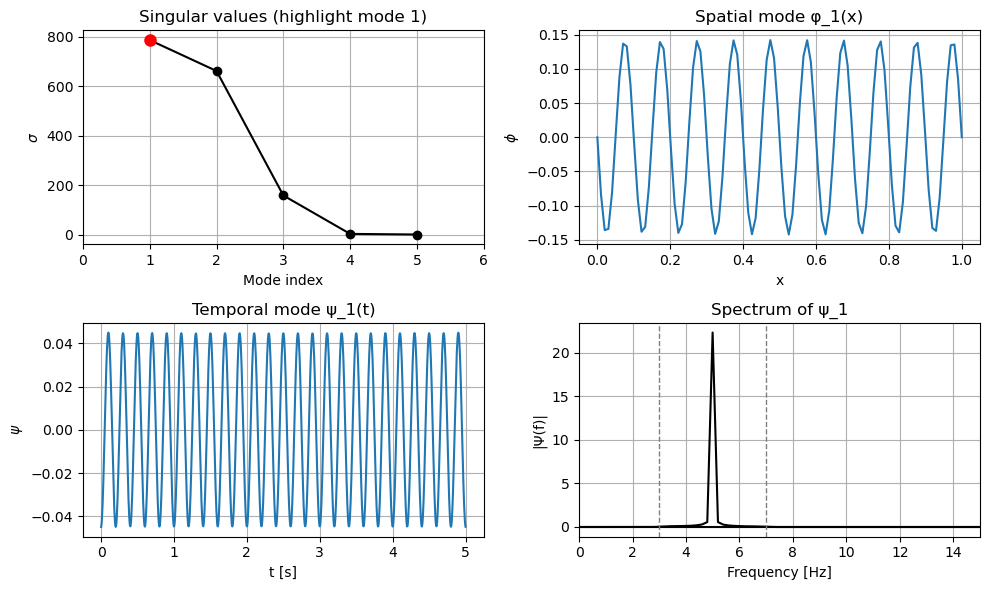

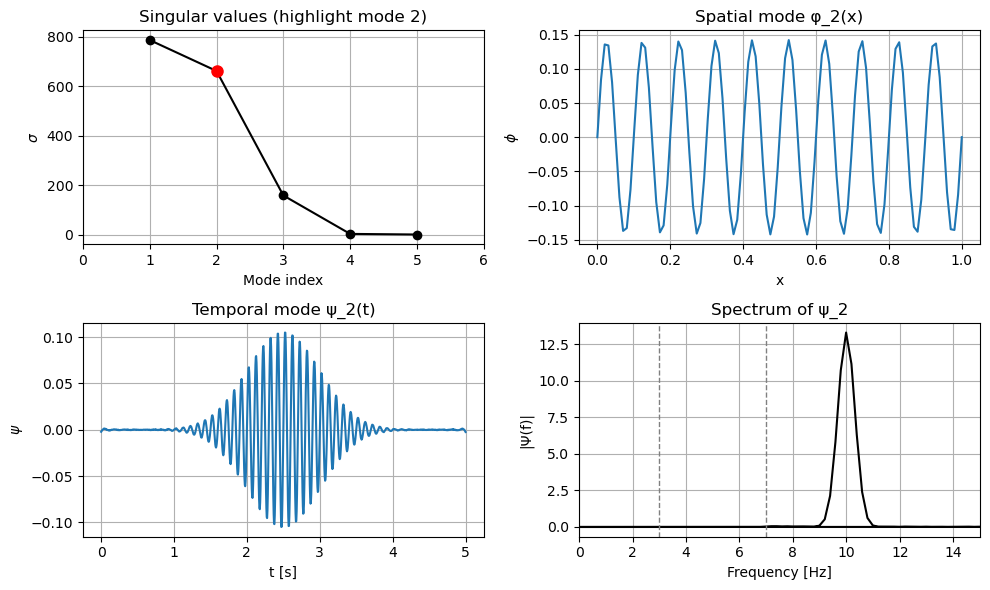

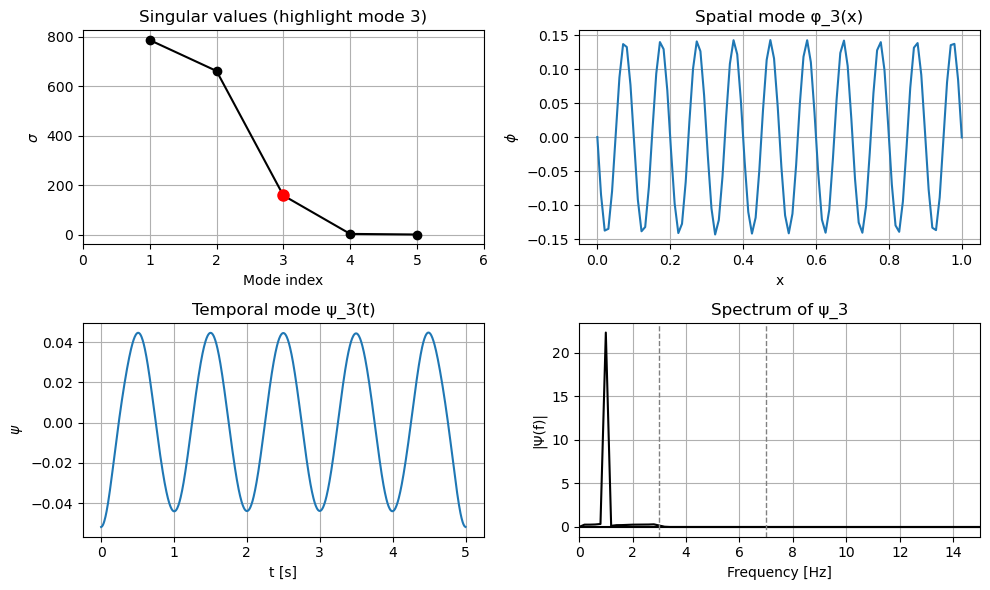

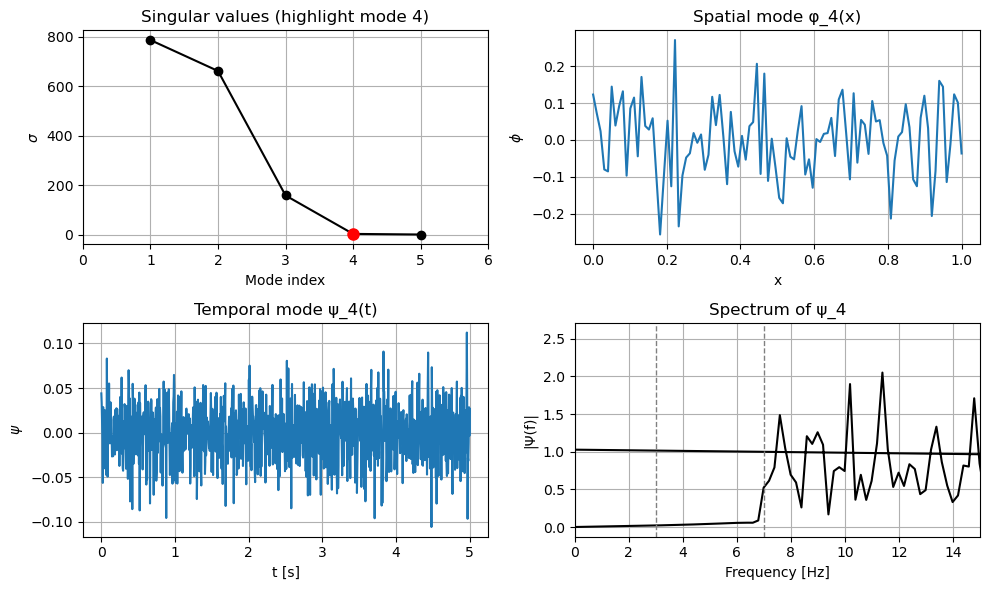

In [230]:
Phi_M, Psi_M, Sigmas_M = phi, psi.T, sigma

Freqs = np.fft.fftfreq(len(t), d=t[1] - t[0]) # now in Hz

for i in range(r-1):
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # Top-left: singular‐value spectrum
    modes = np.arange(1, len(Sigmas_M) + 1)
    axs[0, 0].plot(modes,       Sigmas_M,       'ko-', markersize=6)
    axs[0, 0].plot(i+1,         Sigmas_M[i],    'ro', markersize=8)
    axs[0, 0].set_xlim([0, len(Sigmas_M)+1])
    axs[0, 0].set_xlabel("Mode index")
    axs[0, 0].set_ylabel(r"$\sigma$")
    axs[0, 0].set_title(f"Singular values (highlight mode {i+1})")
    axs[0, 0].grid(True)
    axs[0, 0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Top-right: spatial mode φ_i(x)
    axs[0, 1].plot(x, Phi_M[:, i], '-')
    axs[0, 1].set_xlabel("x")
    axs[0, 1].set_ylabel(r"$\phi$")
    axs[0, 1].set_title(f"Spatial mode φ_{i+1}(x)")
    axs[0, 1].grid(True)

    # Bottom-left: temporal mode ψ_i(t)
    axs[1, 0].plot(t, Psi_M[i, :], '-')
    axs[1, 0].set_xlabel("t [s]")
    axs[1, 0].set_ylabel(r"$\psi$")
    axs[1, 0].set_title(f"Temporal mode ψ_{i+1}(t)")
    axs[1, 0].grid(True)

    # Bottom-right: spectrum of ψ_i(t)
    psi_hat = np.fft.fft(Psi_M[i, :])
    axs[1, 1].plot(Freqs, np.abs(psi_hat), 'k-')
    axs[1, 1].set_xlim([0, 15])
    axs[1, 1].set_xlabel("Frequency [Hz]")
    axs[1, 1].set_ylabel(r"|Ψ(f)|")
    # if you have cut‐freqs F_V, mark them:
    for fc in F_V:
        axs[1, 1].axvline(fc, color='gray', linestyle='--', lw=1)
    axs[1, 1].set_title(f"Spectrum of ψ_{i+1}")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()